## tonygrad DEMO 

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [9]:
import tonygrad
from tonygrad.engine import Value
from tonygrad.nn import Neuron, Layer, MLP
from tonygrad.trace_graph import draw_dot, trace

### example 1

In [20]:
# data, inputs, weights, test backprop function (building the graph manually)

"""tanh() VERSION"""

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
#output
n = x1w1x2w2 + b; n.label = 'n'
#apply tanh to the output 
o = n.tanh(); o.label = 'o'
#launch backprop on the built graph
o.backward()

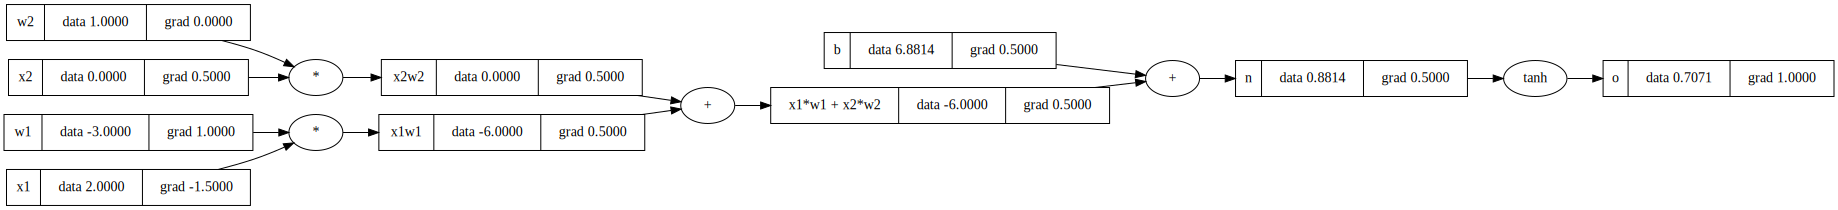

In [21]:
# draw the neural net using graphviz and the draw_dot function

draw_dot(o)

### example 2 (reLU as activation function)

In [22]:
# data, inputs, weights, test backprop function (building the graph manually)

"""reLU VERSION"""

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
#output
n = x1w1x2w2 + b; n.label = 'n'
#apply tanh to the output 
o = n.relu(); o.label = 'o'
#launch backprop on the built graph
o.backward()

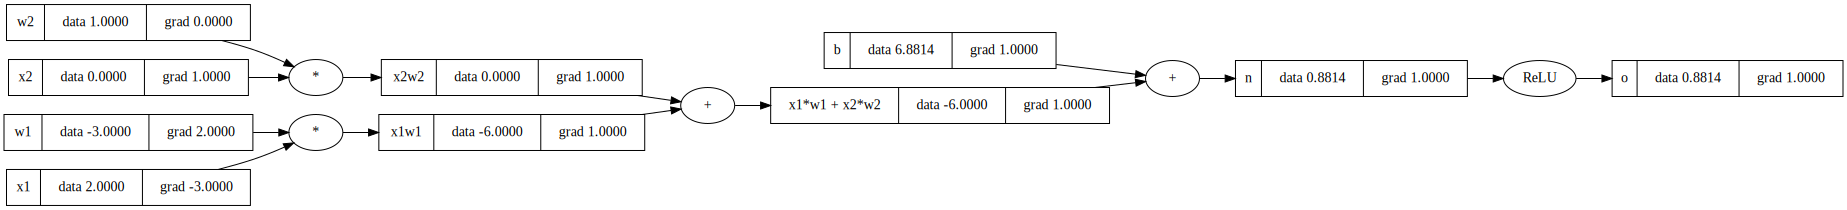

In [23]:
draw_dot(o)

## example 3 (based on karpathy micrograd demo)

In [30]:
np.random.seed(1337)
random.seed(1337)

### building a tiny dataset 

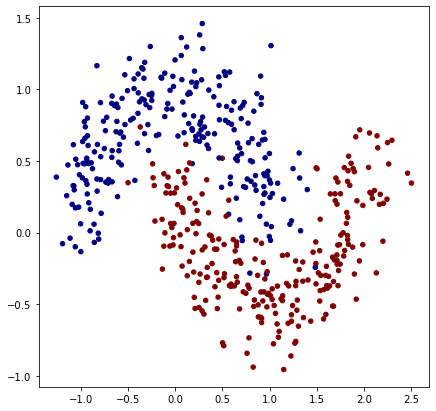

In [31]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=500, noise=0.2)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(7,7))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

### inizialize a simple 2 layer model with the MLP class inside the tonygrad.nn library

In [32]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))


MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


### defining a cost function (loss)

In [33]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.9095349678479343, grad=0) 0.5


### optimization (remember to zero_grad before launching the backpropagation)

In [34]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.9095349678479343, accuracy 50.0%
step 1 loss 1.7079571621519685, accuracy 79.4%
step 2 loss 0.8771342668082048, accuracy 75.6%
step 3 loss 0.7184848203729923, accuracy 83.2%
step 4 loss 0.3896229445822664, accuracy 84.0%
step 5 loss 0.3212385474684587, accuracy 86.2%
step 6 loss 0.2977944833636341, accuracy 88.8%
step 7 loss 0.2866507108766537, accuracy 89.60000000000001%
step 8 loss 0.27709027897718763, accuracy 89.8%
step 9 loss 0.27013548882651595, accuracy 90.0%
step 10 loss 0.2633181378951696, accuracy 90.0%
step 11 loss 0.25820175581069843, accuracy 89.60000000000001%
step 12 loss 0.25405377070866253, accuracy 90.60000000000001%
step 13 loss 0.25019956413041294, accuracy 90.0%
step 14 loss 0.2483291827338477, accuracy 91.2%
step 15 loss 0.24494370603619237, accuracy 90.2%
step 16 loss 0.2401288739194844, accuracy 91.4%
step 17 loss 0.2365380394760614, accuracy 90.8%
step 18 loss 0.23446399161005, accuracy 91.4%
step 19 loss 0.2369732784658949, accuracy 90.2%
step 20

### visualize the decision boundary with numpy and matplotlib

(-1.9560653148762228, 2.2939346851237774)

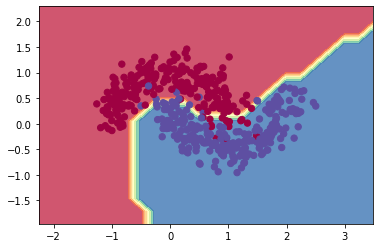

In [35]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
